# Link Analysis: PageRank

*   In this lab we will be exploring the PageRank algorithm and link analysis. Link analysis is a technique for analyzing the structure of a graph by examining the links between the nodes in the graph. Link analysis can be used for a variety of tasks, such as identifying influential nodes, detecting communities, and predicting link formation.

*   PageRank is a link analysis algorithm that was developed by Larry Page and Sergey Brin in the early 1990s. PageRank is used by Google to rank websites in its search engine results pages (SERPs).

*   The PageRank algorithm works by assigning a numerical score to each node in a graph, called the PageRank score. The PageRank score of a node is a measure of how important the node is in the graph.

## Also

In [10]:
import random
from typing import Optional

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

In [11]:
def seed_everything(seed: Optional[int] = None) -> None:
    random.seed(seed)
    np.random.seed(seed)


seed_everything(42)

# Terminology

*   Recall that a stochastic matrix, a.k.a. probability matrix, probability transition matrix, substitution matrix, or Makov matrix, is a matrix used to characterizes transition for a finite Markov chain.

*   Every entry $p_{ij}$ of represents the probability of moving from $i$ to $j$ in unit time steps

    \begin{equation}
        P
        =
        \begin{pmatrix}
            \mathcal{P}(1\vert 1) & \mathcal{P}(1\vert 2) & \ldots & \mathcal{P}(1\vert n) \\
            \mathcal{P}(2\vert 1) & \mathcal{P}(2\vert 2) & \ldots & \mathcal{P}(2\vert n) \\
             &  & \ddots & \\
            \mathcal{P}(n\vert 1) & \mathcal{P}(n\vert 2) & \ldots & \mathcal{P}(n\vert n) \\
        \end{pmatrix}
    \end{equation}

*   Since the transition probabily from the $i$-th state to all other states has to be equal to 1 we

    \begin{equation}
        \sum_{i}^{n} P(i \vert j) = 1
    \end{equation}

# PageRank Overview

\begin{equation}
    Av = \lambda v
    \quad \rightarrow \quad
    Av = 1v
\end{equation}

*   $v$ is the eigenvector that corresponds to the highest eigenvalue with modulus $\left\vert \lambda \right\vert\leq1$
*   the matrix $A$ is column-normalized
*   the **Perron-Frobenius** theorem guarantees that such eigenvalue $\lambda$ exists and therefore its respective eigenvector $v$

# PageRank Algorithm

Make a small perturbation of the previous model as follows:

\begin{equation}
    (\text{perturbation})Av + \text{perturbation} \approx 1v
    \quad \rightarrow \quad
    \alpha Av + (1-\alpha)\frac{1}{n} = v
    \quad \rightarrow \quad
    X(\alpha, n) v_{t} = v_{t+1}
\end{equation}

    
*   where $\alpha$ denotes the random probability and $n$ is the scaling factor
*   this can be reinterpreted as a dynamical system with an initial state that evolves over time
*   the only thing requiered are the graph edges
*   it is better than the degree centrality
*   it is fast to compute for large graphs, i.e. it has a linear runtime with respect to the number of edges $\mathcal{O}(E)$

# Example: Flow Equations & M

In [12]:
def get_stochastic_adjacency_matrix(G: nx.Graph) -> np.ndarray:
    nodes = list(G.nodes())
    num_nodes = len(nodes)
    M = np.zeros((num_nodes, num_nodes))
    for j, node_j in enumerate(nodes):
        in_edges = G.in_edges(node_j)
        for in_edge in G.in_edges(node_j):
            node_i = in_edge[0]
            i = nodes.index(node_i)
            M[j, i] += 1.0 / G.out_degree(node_i)

    return M


# Or, more concise but slower:

# def get_stochastic_adjacency_matrix(G: nx.Graph) -> np.ndarray:
#    A = nx.adjacency_matrix(G).todense().astype(float)
#    out_degrees = np.array([degree[1] for degree in G.out_degree()])
#    return np.divide(A, out_degrees, out=np.zeros_like(A), where=out_degrees != 0)

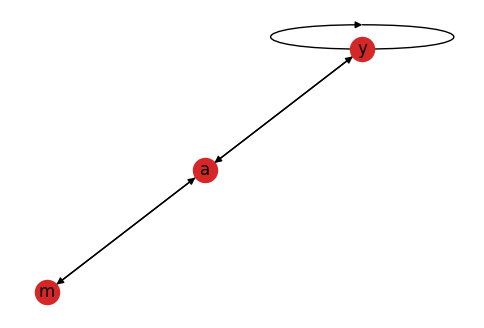


Stochastic Adjacency Matrix M (nodes ['y', 'a', 'm']):
[[0.5 0.5 0. ]
 [0.5 0.  1. ]
 [0.  0.5 0. ]]


In [13]:
edge_list = [
    ("y", "a"),
    ("y", "y"),
    ("a", "m"),
    ("a", "y"),
    ("m", "a")
]

G = nx.DiGraph(edge_list)
pos = nx.circular_layout(G)
M = get_stochastic_adjacency_matrix(G)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)
nx.draw(G, node_color="tab:red", node_size=300, with_labels=True, ax=ax)
plt.show()

print(f"\nStochastic Adjacency Matrix M (nodes {G.nodes()}):")
print(M)

# PageRank Algorithm Explanation

1. **Initialization**:
    - We represent the graph using a **stochastic adjacency matrix** \( $M$ \), where each element \( $M_{ij}$ \) represents the probability of transitioning from node \( i \) to node \( j \). This matrix is built based on the graph structure, where the links are normalized by the number of outgoing links from each node.
    - We start by assigning **equal rank** to all nodes, i.e., each node gets a PageRank value of \( $\frac{1}{n}$ \), where \( $n$ \) is the total number of nodes in the graph.

2. **Damping Factor** (\( $\alpha$ \)):
    - The damping factor, typically set to \( 0.85 \), accounts for the possibility that a random surfer may either follow a link (with probability \( $\alpha$ \)) or jump to any random page (with probability \( $1 - \alpha$ \)). This is important to ensure that the PageRank algorithm handles "dangling nodes" (pages with no outbound links) and that it converges.

3. **Power Iteration**:
    - The PageRank values are updated iteratively using the power iteration method. At each iteration, the new rank for each node is computed as:
    
    
    
       newRank = $\alpha M \times \text{rank} + \frac{(1 - \alpha)}{n}$
    
    
    
    - This formula has two parts:
        1. \( $\alpha M \times$ rank \): The probability of following a link from one page to another, weighted by the importance of the pages linking to it.
        2. \( $\frac{(1 - \alpha)}{n}$ \): The probability of jumping to a random page.
        
4. **Convergence**:
    - The algorithm repeats the rank calculation until the change in PageRank values between two iterations is less than a small threshold (the **tolerance** \( $\text{tol}$ \)). This ensures the algorithm has converged, and the ranks are stable.

5. **Final Output**:
    - After convergence, the algorithm returns the final PageRank values for each node, which represent their relative importance in the graph.

### Key Concepts:
- **Stochastic Matrix**: A matrix where the sum of the entries in each column is 1, representing probabilities of moving between nodes.
- **Damping Factor**: Controls the likelihood of randomly jumping to another node. A higher damping factor means more weight is given to following links.

### Why is PageRank Effective?
- **Connectivity**: PageRank takes into account both the number of links and the importance of the pages that link to a given node.
- **Random Surfer Model**: This ensures that even pages with no links pointing to them can have some rank, making the algorithm robust.

### Steps of the Algorithm:
1. **Initialize** the ranks uniformly.
2. **Iterate** by updating the ranks using the formula:
   
   newRank = $\alpha M \times \text{rank} + \frac{(1 - \alpha)}{n}$
   
3. **Check for convergence** based on the change in PageRank values.
4. **Return** the final ranks once the algorithm has converged.

In [35]:
def my_page_rank(G: nx.Graph, alpha=0.85, tol=1.0e-6) -> dict:
    """
    Compute the PageRank for the graph G using the power iteration method.
    
    Parameters:
    G (nx.Graph): The directed graph for which to compute PageRank.
    alpha (float): The damping factor (typically 0.85).
    tol (float): Tolerance for convergence.

    Returns:
    dict: A dictionary containing the PageRank values for each node.
    """
    
    # Step 1: Get the list of nodes
    nodes = list(G.nodes())
    num_nodes = len(nodes)
    
    # Step 2: Initialize the PageRank vector (all nodes start with equal rank)
    ranks = np.ones(num_nodes) / num_nodes
    
    # Step 3: Build the stochastic adjacency matrix
    M = get_stochastic_adjacency_matrix(G)

    # Step 4: Power iteration loop
    while True:
        # Compute the new rank vector
        new_ranks = alpha * np.dot(M, ranks) + (1 - alpha) / num_nodes
        
        # Check for convergence (if the change is less than tolerance tol)
        if np.linalg.norm(new_ranks - ranks, 1) < tol:
            break
        
        # Update the ranks for the next iteration
        ranks = new_ranks
    
    # Return the ranks as a dictionary with node labels
    return {node: rank for node, rank in zip(nodes, ranks)}

In [36]:
def pagerank_example(
    personalization: Optional[dict] = None,
    spring_layout_k: float = 5.0,
    label_rank_threshold: float = 0.02,
    cmap_name: str = "viridis",
    node_size_factor: float = 2e4,
    width: float = 1.5,
    font_size: int = 16,
    seed: Optional[int] = 42,
    ax = None
) -> None:
    edge_list = [
        ("B", "C"),
        ("C", "B"),
        ("D", "A"),
        ("D", "B"),
        ("E", "B"),
        ("E", "D"),
        ("E", "F"),
        ("F", "B"),
        ("F", "E"),
        ("G", "B"),
        ("G", "E"),
        ("H", "B"),
        ("H", "E"),
        ("I", "B"),
        ("I", "E"),
        ("J", "E"),
        ("K", "E"),
    ]
    G = nx.DiGraph(edge_list)
    ranks = my_page_rank(G)
    max_rank = max(ranks.values())
    node_sizes = [max(100.0, node_size_factor * rank / max_rank) for node, rank in ranks.items()]
    cmap = plt.get_cmap(cmap_name)
    node_colors = [cmap(rank / max_rank) for node, rank in ranks.items()]
    node_lables = {
        node: f"{node}\n{100 * ranks[node]:.1f}" if ranks[node] > label_rank_threshold else "" for node in G.nodes
    }
    pos = nx.spring_layout(G, k=spring_layout_k, seed=seed)
    nx.draw(
        G,
        pos=pos,
        node_color=node_colors,
        labels=node_lables,
        edgecolors="black",
        node_size=node_sizes,
        width=1.5,
        font_size=font_size,
        ax=ax
    )

## PageRank

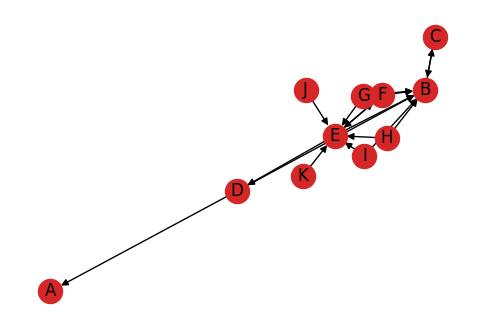

In [37]:
edge_list = [
    ("B", "C"),
    ("C", "B"),
    ("D", "A"),
    ("D", "B"),
    ("E", "B"),
    ("E", "D"),
    ("E", "F"),
    ("F", "B"),
    ("F", "E"),
    ("G", "B"),
    ("G", "E"),
    ("H", "B"),
    ("H", "E"),
    ("I", "B"),
    ("I", "E"),
    ("J", "E"),
    ("K", "E"),
]

G = nx.DiGraph(edge_list)
pos = nx.circular_layout(G)
M = get_stochastic_adjacency_matrix(G)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)
nx.draw(G, node_color="tab:red", node_size=300, with_labels=True, ax=ax)
plt.show()

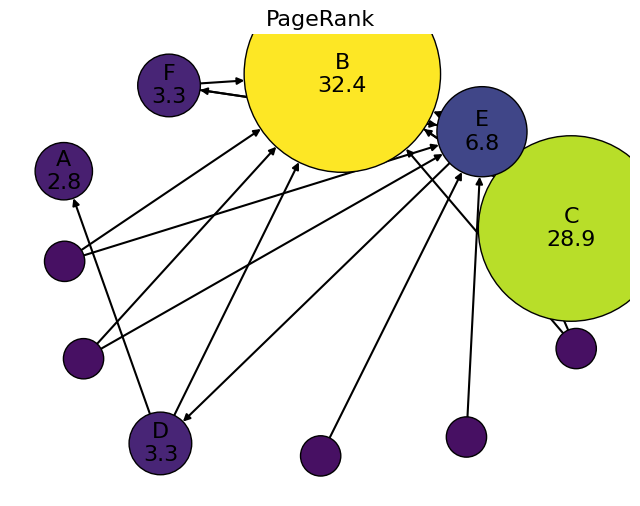

In [38]:
personalization = None  # Equivalent to {"A": 1 / num_nodes, "B": 1 / num_nodes, ...}
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
ax.set_axis_off()
ax = fig.add_subplot(1, 1, 1)
pagerank_example(personalization=personalization, ax=ax)
plt.title("PageRank", fontsize=16)
plt.show()

# Personalized PageRank

The same approach is followed, and in this case we have:

\begin{equation}
    (\text{perturbation})Av + \text{perturbation} \approx 1v
    \quad \rightarrow \quad
    \alpha Av + (1-\alpha)\frac{1\text{ or } 0}{n} = v
    \quad \rightarrow \quad
    X(\alpha, n) v_{t} = v_{t+1}
\end{equation}

    
*   where $1$ represents the prefered nodes and $0$ the ones that are to be excluded
*   these systems are ideal for recommendation, e.g. if one node is prefered then it can detect what other node is likely to be preferred as well, where preferred can be, likes, purchases, views, etc.
*   it works on ANY graph!

\begin{equation}
    v_{t+1} = v_{t}f(\alpha, n, p_{1,0})
\end{equation}

## The Algorithm:

1. **Initialization**:
    - We represent the graph using a **stochastic adjacency matrix** $M$, where each element $M_{ij}$ represents the probability of transitioning from node $i$ to node $j$.
    - We introduce a **personalization vector** $p$, where each element is either 1 (preferred node) or 0 (non-preferred node). This vector biases the random jump step towards the preferred nodes.

2. **Modified Damping Factor**:
    - In traditional PageRank, the random surfer can jump to any node with equal probability. In **Personalized PageRank**, the random jumps are biased by the **personalization vector** $p$, so the surfer is more likely to jump to a preferred node.
    - The equation becomes:

    $$
    v_{t+1} = \alpha M v_{t} + (1 - \alpha) p
    $$

    Where:
    - $\alpha M v_t$: Represents the probability of following a link from one node to another.
    - $(1 - \alpha) p$: Represents the probability of jumping to a preferred node, weighted by the personalization vector $p$.

3. **Power Iteration**:
    - The Personalized PageRank values are updated iteratively until convergence. The equation iterates as:

    $$
    v_{t+1} = \alpha M v_{t} + (1 - \alpha) p
    $$

    - This formula ensures that nodes linked by other important nodes will receive a higher rank, and the personalization bias is incorporated at each iteration.

4. **Convergence**:
    - The algorithm repeats the rank calculation until the difference between the current and previous rank vectors becomes smaller than a predefined tolerance $\text{tol}$. This ensures the algorithm converges and the ranks are stable.

5. **Recommendation**:
    - After convergence, the algorithm outputs the Personalized PageRank values for all nodes. The nodes with the highest ranks are those that are most closely related to the preferred nodes, making it useful for recommending items, content, or products.

### Key Concepts:
- **Personalization Vector**: A vector $p$ that prioritizes certain nodes by assigning 1 to preferred nodes and 0 to others.
- **Damping Factor**: Controls the probability of following links versus jumping to a node based on user preferences. Typically set to $\alpha = 0.85$, meaning there's an 85% chance of following a link and a 15% chance of jumping to a preferred node.
- **Stochastic Matrix**: A matrix $M$ that represents transition probabilities between nodes, where the sum of each column is 1.

### Steps of the Algorithm:
1. **Initialize** the ranks uniformly across all nodes.
2. **Set up the personalization vector** based on user preferences, ensuring it sums to 1.
3. **Iterate** using the formula:

    $$
    v_{t+1} = \alpha M v_{t} + (1 - \alpha) p
    $$

4. **Check for convergence** by comparing the change in rank values between iterations.
5. **Return the final ranks**, which are biased toward the preferred nodes.

### Why Personalized PageRank is Effective:
- **Preference Incorporation**: Personalized PageRank takes into account specific user preferences, allowing it to tailor recommendations based on these inputs.
- **Robust for Any Graph**: The algorithm works on any graph and can be adapted to various use cases, such as recommending web pages, products, or social media content.

### Example:
- Suppose we want to recommend movies to a user. We can create a graph where each node is a movie, and edges represent relationships between movies (e.g., users who liked both movies). We can then set the personalization vector to 1 for movies the user already likes. The algorithm will rank other movies based on how closely they are related to the preferred ones.

In [45]:
import numpy as np
import networkx as nx

def my_personalized_page_rank(G: nx.Graph, personalization: dict, alpha=0.85, tol=1.0e-6) -> dict:
    """
    Compute the Personalized PageRank for the graph G.
    
    Parameters:
    G (nx.Graph): The directed graph for which to compute Personalized PageRank.
    personalization (dict): A dictionary where the keys are node IDs and values are 1 for preferred nodes, 0 for non-preferred.
    alpha (float): The damping factor (typically 0.85).
    tol (float): Tolerance for convergence.

    Returns:
    dict: A dictionary containing the Personalized PageRank values for each node.
    """
    
    # Step 1: Get the list of nodes and the number of nodes
    nodes = list(G.nodes())
    num_nodes = len(nodes)
    
    # Step 2: Initialize the PageRank vector (all nodes start with equal rank)
    ranks = np.ones(num_nodes) / num_nodes
    
    # Step 3: Build the stochastic adjacency matrix
    M = get_stochastic_adjacency_matrix(G)

    # Step 4: Construct the personalization vector from the provided dictionary
    p = np.zeros(num_nodes)
    for node, value in personalization.items():
        if node in nodes:
            i = nodes.index(node)
            p[i] = value
    
    # Ensure the personalization vector sums to 1 (normalize it)
    p = p / np.sum(p)
    
    # Step 5: Power iteration loop
    while True:
        # Compute the new rank vector
        new_ranks = alpha * np.dot(M, ranks) + (1 - alpha) * p
        
        # Check for convergence (if the change is less than tolerance tol)
        if np.linalg.norm(new_ranks - ranks, 1) < tol:
            break
        
        # Update the ranks for the next iteration
        ranks = new_ranks
    
    # Return the ranks as a dictionary with node labels
    return {node: rank for node, rank in zip(nodes, ranks)}

In [46]:
def personalized_pagerank_example(
    personalization: Optional[dict] = None,
    spring_layout_k: float = 5.0,
    label_rank_threshold: float = 0.02,
    cmap_name: str = "viridis",
    node_size_factor: float = 2e4,
    width: float = 1.5,
    font_size: int = 16,
    seed: Optional[int] = 42,
    ax = None
) -> None:
    edge_list = [
        ("B", "C"),
        ("C", "B"),
        ("D", "A"),
        ("D", "B"),
        ("E", "B"),
        ("E", "D"),
        ("E", "F"),
        ("F", "B"),
        ("F", "E"),
        ("G", "B"),
        ("G", "E"),
        ("H", "B"),
        ("H", "E"),
        ("I", "B"),
        ("I", "E"),
        ("J", "E"),
        ("K", "E"),
    ]
    G = nx.DiGraph(edge_list)
    ranks = my_personalized_page_rank(G, personalization)
    max_rank = max(ranks.values())
    node_sizes = [max(100.0, node_size_factor * rank / max_rank) for node, rank in ranks.items()]
    cmap = plt.get_cmap(cmap_name)
    node_colors = [cmap(rank / max_rank) for node, rank in ranks.items()]
    node_lables = {
        node: f"{node}\n{100 * ranks[node]:.1f}" if ranks[node] > label_rank_threshold else "" for node in G.nodes
    }
    pos = nx.spring_layout(G, k=spring_layout_k, seed=seed)
    nx.draw(
        G,
        pos=pos,
        node_color=node_colors,
        labels=node_lables,
        edgecolors="black",
        node_size=node_sizes,
        width=1.5,
        font_size=font_size,
        ax=ax
    )

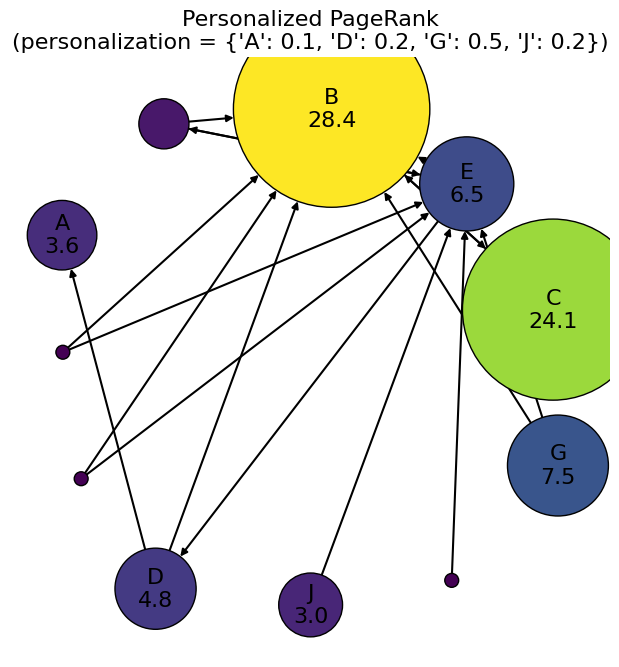

In [50]:
personalization = {"A": 0.1, "D": 0.2, "G": 0.5, "J": 0.2}

plt.figure(figsize=(6, 6))
personalized_pagerank_example(personalization=personalization)
plt.title(f"Personalized PageRank\n(personalization = {personalization})", fontsize=16)
plt.show()

## Random Walk with Restarts (RWR)

### Overview:
**Random Walk with Restarts (RWR)** is a variant of the standard random walk algorithm on a graph, where the walker has a chance of returning to a specific starting node (called the **restart node**) at each step. This makes it suitable for tasks like personalized recommendations, where we want to keep the walk focused around a particular node of interest.

### The Algorithm:

1. **Initialization**:
    - We represent the graph using a **stochastic adjacency matrix** $M$, where each element $M_{ij}$ represents the probability of transitioning from node $i$ to node $j$.
    - A **restart probability** $\alpha$ controls the likelihood that the walker will return to the starting node (the **seed node**). The remaining probability $1 - \alpha$ represents the chance of continuing the random walk.

2. **Random Walk with Restart Formula**:
    - At each iteration, the walker has two options:
      1. With probability $\alpha$, the walker returns to the seed node.
      2. With probability $1 - \alpha$, the walker transitions to a neighboring node based on the structure of the graph.
      
    The equation governing this process is:

    $$
    v_{t+1} = \alpha e + (1 - \alpha) M v_t
    $$

    Where:
    - $v_t$: The rank vector at time step $t$.
    - $e$: The **restart vector**, where $e_i = 1$ for the restart node and $e_i = 0$ for all other nodes.
    - $M$: The stochastic adjacency matrix representing the graph structure.
    - $\alpha$: The restart probability.

3. **Power Iteration**:
    - Like PageRank, the RWR algorithm iterates until convergence. At each iteration, the rank vector is updated using the formula above, ensuring that at each step, the walker has a chance of returning to the restart node.

4. **Convergence**:
    - The algorithm repeats the rank calculation until the change between the current and previous rank vectors becomes smaller than a predefined tolerance $\text{tol}$. Once this condition is met, the algorithm stops, and the final rank values are output.

5. **Applications**:
    - RWR is especially useful for **personalized recommendation systems**. For example, if a user shows interest in a particular item (the seed node), RWR can recommend other items that are closely related, while maintaining a bias toward the seed node.

### Key Concepts:
- **Restart Vector**: The vector $e$ specifies the restart node, with $e_i = 1$ for the restart node and $e_i = 0$ for all others.
- **Restart Probability**: The probability $\alpha$ represents the chance of returning to the restart node. A typical value is $\alpha = 0.85$, meaning there's an 85% chance of returning to the seed node and a 15% chance of continuing the random walk.
- **Stochastic Matrix**: A matrix $M$ where each column sums to 1, representing the transition probabilities between nodes in the graph.

### Steps of the Algorithm:
1. **Initialize** the rank vector, starting with uniform probabilities for all nodes.
2. **Set up the restart vector** $e$, where the entry corresponding to the seed node is 1 and all others are 0.
3. **Iterate** using the formula:

    $$
    v_{t+1} = \alpha e + (1 - \alpha) M v_t
    $$

4. **Check for convergence** by comparing the change in rank values between iterations.
5. **Return the final ranks**, which are biased toward the restart node.

### Why RWR is Effective:
- **Bias Toward the Restart Node**: RWR maintains a strong focus on the restart node, making it ideal for tasks like personalized recommendations or identifying key relationships around a specific node.
- **Works for Any Graph**: RWR can be applied to any type of graph, whether it's a social network, web graph, or product graph.

### Example:
- Suppose we want to recommend products to a user. We can create a graph where each node represents a product, and edges represent similarities or co-purchases between products. We can then use RWR, setting the user's favorite product as the restart node. The algorithm will rank other products based on how closely they are related to the favorite product, while frequently restarting the walk at that product.

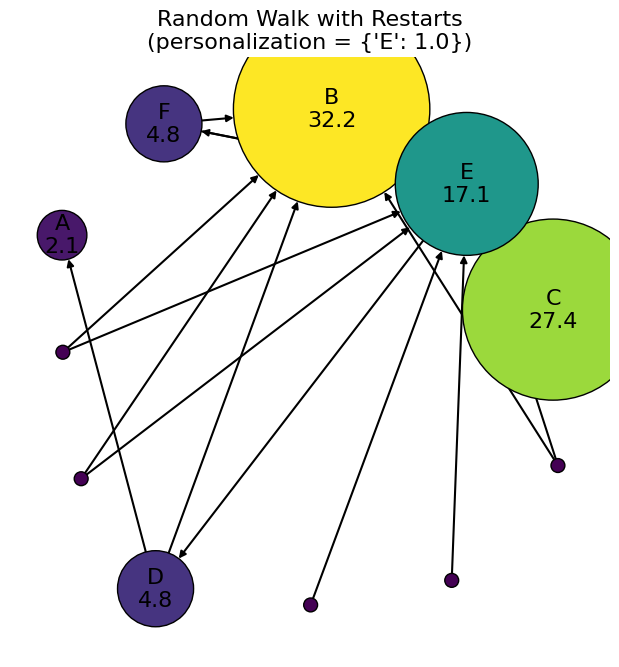

In [57]:
personalization = {"E": 1.0}

plt.figure(figsize=(6, 6))
personalized_pagerank_example(personalization=personalization)
plt.title(f"Random Walk with Restarts\n(personalization = {personalization})", fontsize=16)
plt.show()